# **Report Group 12** 


#### **Loading packages**


In [ ]:
from datetime import datetime

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import wandb
from gymPacMan import gymPacMan_parallel_env
import torch.nn.functional as F
from collections import deque
import random
import os
from dataclasses import dataclass
import pandas as pd

import cProfile
import pstats

torch.autograd.set_detect_anomaly(True)


if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

wandb.login(key = '', relogin = True)


from util_functions import *


Running on the GPU


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\josse\_netrc


Running on the GPU


# **Section 1: All functions**

## **Networks**


### Agent networks


#### CNN

In [4]:
class AgentQNetwork(nn.Module):
    def __init__(self,obs_shape, action_dim,hidden_dim=64):
        super(AgentQNetwork, self).__init__()
        self.c1 = nn.Conv2d(obs_shape[0], 32, kernel_size=3, stride=1, padding=1)
        self.c2 = nn.Conv2d(32, hidden_dim, kernel_size=3, stride=1, padding=1)
        self.c3 = nn.Conv2d(hidden_dim, 4*hidden_dim, kernel_size=3, stride=1, padding=1)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(4*hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)


    def forward(self, obs):
        x = torch.relu(self.c1(obs))
        x = torch.relu(self.c2(x))
        x = torch.relu(self.c3(x))
        x = self.global_pool(x)
        x = torch.flatten(x, start_dim=1)
        x = torch.relu(self.fc1(x))
        q_values = self.fc2(x)
        return q_values

#### CNN with attention

#### LSTM

In [5]:
# Define the CNN-LSTM-Q Network


class CNNLSTMQNetwork_hidden(nn.Module):
    def __init__(self, embed_dim, obs_shape, action_space):
        super(CNNLSTMQNetwork_hidden, self).__init__()
        self.embed_dim = embed_dim

        # Shared encoder for the agent's state
        self.shared_encoder = nn.Sequential(
            nn.Conv2d(obs_shape[0], 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Adaptive pooling to handle varying input sizes
        )

        # Fully connected layer to project encoded state to embed_dim
        self.fc = nn.Linear(128 * 1 * 1, embed_dim)

        # LSTM layer to model temporal dependencies
        self.lstm = nn.LSTM(embed_dim, embed_dim, num_layers=1, batch_first=True)

        # Final layer to compute Q-values
        self.final_layer = nn.Sequential(
            nn.Linear(embed_dim, action_space),
            nn.SiLU()  # Swish activation
        )

    def forward(self, state, hidden):
        # Process single state using the shared encoder
        cnn_features = []
        for t in range(5):
            
            encoded_state = self.shared_encoder(state[:, t, :, :, :])  # Encode the state
            encoded_state = encoded_state.view(encoded_state.size(0), -1)  # Flatten to [batch_size, 128 * 1 * 1]
            projected_state = self.fc(encoded_state).unsqueeze(1)  # Project to embed_dim and add sequence dimension
            cnn_features.append(projected_state)
            
        cnn_features = torch.cat(cnn_features, dim=1)  # Shape: (batch_size, seq_len, cnn_output_size)
        # Apply LSTM to model temporal dependencies
        hx, cx = hidden[0, :, :, :], hidden[1, :, :, :]
        lstm_out, (hx, cx) = self.lstm(cnn_features, (hx, cx))
        hidden_new = torch.stack([hx.detach(), cx.detach()], dim=0)
        # Use the output of the LSTM for the final layer
        q_values = self.final_layer(lstm_out[:, -1, :])  # Shape: [batch_size, action_space]

        return q_values, hidden_new

    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.embed_dim),
                torch.zeros(1, batch_size, self.embed_dim))


### Mixing Networks

#### Simple

In [6]:
class SimpleQMixer(nn.Module):
    def __init__(self, n_agents, state_shape):
        super(SimpleQMixer, self).__init__()

        self.n_agents = n_agents
        self.state_shape = state_shape
        print(state_shape)
        # Much simpler state processing
        self.state_conv = nn.Sequential(
            nn.Conv3d(state_shape[0], 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * state_shape[1] * state_shape[2] * state_shape[3],  n_agents)  # Output: (batch_size, 32 * n_agents)
        )
        # Initialize weights positively
        for m in self.state_conv:
            if isinstance(m, nn.Conv3d) or isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, 0.9, 1.1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)
        # Single layer mixing network
        self.mixing_layer = nn.Linear(n_agents , 1, bias=False)

        # Initialize close to equal weights_enemy
        nn.init.uniform_(self.mixing_layer.weight, 0.9, 1.1)

    def forward(self, agent_qs, states):

        bs = agent_qs.size(0)
        weights_enemy = F.softplus(self.state_conv(states))


        agent_qs = agent_qs.view(-1, 1, self.n_agents)

        weighted_qs = agent_qs * weights_enemy.unsqueeze(1)

        q_tot = self.mixing_layer(weighted_qs.squeeze(1))
        return q_tot.view(bs, -1, 1)



#### Attention

In [7]:

class AttentionMixer(nn.Module):
    def __init__(self, n_agents, state_shape=(2, 8, 10, 20), embed_dim=32, n_heads=4):
        super(AttentionMixer, self).__init__()

        self.n_agents = n_agents
        self.state_shape = state_shape[1:]  # Remove agent dimension
        self.embed_dim = embed_dim
        self.n_heads = n_heads

        # Shared Conv2D encoder for each agent
        self.shared_encoder = nn.Sequential(
            nn.Conv2d(self.state_shape[0], 16, kernel_size=3, stride=1, padding='same'),
            nn.SiLU(),  # Swish activation
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding='same'),
            nn.SiLU(),  # Swish activation
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same'),
            nn.SiLU(),  # Swish activation
            nn.AdaptiveAvgPool2d(1)
        )

        # Fully connected layer to project to embed_dim
        self.fc = nn.Sequential(
            nn.Linear(64, embed_dim),
            nn.SiLU()  # Swish activation
        )

        for m in self.shared_encoder:
            if isinstance(m, nn.Conv2d):
                nn.init.uniform_(m.weight, 0.9, 1.1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)
        for m in self.fc:
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, 0.9, 1.1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)

        # Multi-head attention for inter-agent interaction
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=n_heads, batch_first=True)

        # Hypernetwork for mixing weights_enemy and biases
        self.hyper_w = nn.Sequential(
            nn.Linear(embed_dim * n_agents, embed_dim * embed_dim),
            nn.SiLU(),  # Swish activation
            nn.Linear(embed_dim * embed_dim, n_agents * embed_dim)
        )
        self.hyper_b = nn.Sequential(
            nn.Linear(embed_dim * n_agents, embed_dim),
            nn.SiLU(),  # Swish activation
            nn.Linear(embed_dim, embed_dim)
        )

        # Final layer to compute Q_tot
        self.final_layer = nn.Sequential(
            nn.Linear(embed_dim, 1),
            nn.SiLU()  # Swish activation
        )

        for m in self.hyper_w:
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, 0.9, 1.1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)

        for m in self.hyper_b:
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, 0.9, 1.1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)

        for m in self.final_layer:
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, 0.9, 1.1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)


    def forward(self, agent_qs, states):
        batch_size = states.size(0)

        # Process each agent's state individually using the shared encoder
        agent_features = []
        for i in range(self.n_agents):
            agent_state = states[:, i, :, :, :]  # Shape: [batch_size, 8, 10, 20]
            encoded_state = self.shared_encoder(agent_state)  # Encode individual agent
            encoded_state = encoded_state.view(batch_size, -1)  # Flatten to [batch_size, 128]
            projected_state = self.fc(encoded_state)  # Project to embed_dim
            agent_features.append(projected_state)

        # Stack agent features: Shape [batch_size, n_agents, embed_dim]
        agent_features = torch.stack(agent_features, dim=1)

        # Apply attention to model inter-agent interaction
        attention_out, _ = self.attention(agent_features, agent_features, agent_features)

        # Flatten attention output for hypernetwork
        attention_out_flat = attention_out.reshape(batch_size, -1)  # Shape: [batch_size, n_agents * embed_dim]

        # Compute hypernetwork weights and biases
        hyper_w = F.softplus(self.hyper_w(attention_out_flat).view(batch_size, self.n_agents, self.embed_dim))
        hyper_b = self.hyper_b(attention_out_flat).view(batch_size, self.embed_dim)

        # Combine agent Q-values with weights and biases
        agent_qs = agent_qs.view(batch_size, self.n_agents, 1)  # Shape: [batch_size, n_agents, 1]
        weighted_qs = torch.bmm(agent_qs.transpose(1, 2), hyper_w).squeeze(1) + hyper_b

        # Final projection to Q_tot
        q_tot = self.final_layer(weighted_qs).unsqueeze(1)
        return q_tot


## **Loss calculations**



### IQL

In [8]:

def compute_td_loss_iql(agent_q_networks, target_q_networks, batch, weights=None, gamma=0.99, lambda_=0.1):
    """
    Computes the TD loss for QMix training using the Huber loss.

    Args:
        agent_q_networks (list): List of Q-networks for each agent.
        mixing_network (SimpleQMixer): The mixing network to compute global Q-values.
        target_q_networks (list): List of target Q-networks for each agent.
        batch (tuple): A batch of experiences (states, actions, rewards, next_states, dones).
        weights (torch.Tensor): Importance sampling weights (optional).
        gamma (float): Discount factor for future rewards.
        lambda_ (float): Regularization factor for stability.

    Returns:
        torch.Tensor: Total loss for training.
    """
    states, actions, rewards, next_states, dones = batch

    # Convert to tensors and move to device
    states = torch.tensor(states, dtype=torch.float32).to(device)
    actions = torch.tensor(actions, dtype=torch.long).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)

    # Current Q-values for each agent
    agent_q_values = []
    for agent_index, q_net in enumerate(agent_q_networks):
        q_vals = q_net(states[:, agent_index, :, :, :])  # Get Q-values for each agent
        agent_q_values.append(
            q_vals.gather(dim=1, index=actions[:, agent_index].unsqueeze(1)))  # Select Q-value for taken action
    agent_q_values = torch.cat(agent_q_values, dim=1)  # Shape: (batch_size, n_agents)

    # Target Q-values using Double DQN
    with torch.no_grad():
        # Get actions from current Q-networks
        next_agent_q_values = []
        for agent_index, (q_net, target_net) in enumerate(zip(agent_q_networks, target_q_networks)):
            next_q_vals = q_net(next_states[:, agent_index, :, :, :])  # Get Q-values from current network
            max_next_actions = next_q_vals.argmax(dim=1, keepdim=True)  # Greedy actions
            target_q_vals = target_net(next_states[:, agent_index, :, :, :])  # Get Q-values from target network\
            max_next_q_vals = target_q_vals.gather(1, max_next_actions)
            done_mask = dones[:, 0, 0].unsqueeze(1)
            filtered_target_q_vals = max_next_q_vals * (1 - done_mask)

            next_agent_q_values.append(filtered_target_q_vals)  # Use target Q-values for selected actions
        next_agent_q_values = torch.cat(next_agent_q_values, dim=1)  # Shape: (batch_size, n_agents)

    # Independent Q-learning target for each agent (all members of the blue team receive the same reward)
    target_q = rewards[:, 0, 0].unsqueeze(1) + gamma * next_agent_q_values

    # Compute Huber loss, try also with MSE loss
    loss_fn = torch.nn.HuberLoss()

    loss_agent1 = loss_fn(agent_q_values[:, 0], target_q[:, 0])
    loss_agent2 = loss_fn(agent_q_values[:, 1], target_q[:, 1])

    return loss_agent1, loss_agent2

### Mixed Q-Learning


### Mixed Q-Learning for LSTM

## **Replay buffers**

### Normal buffer

In [9]:

class ReplayBuffer:
    def __init__(self, buffer_size=10000):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        experiences = random.sample(self.buffer, batch_size)

        # Restructure the batch into separate arrays for states, actions, rewards, next_states, and dones
        states = np.array([exp[0].cpu().numpy() for exp in experiences], dtype=np.float32)
        actions = np.array([exp[1] for exp in experiences], dtype=np.int64)
        rewards = np.array([exp[2] for exp in experiences])
        next_states = np.array([exp[3].cpu().numpy() for exp in experiences])
        dones = np.array([exp[4] for exp in experiences])

        return states, actions, rewards, next_states, dones

    def size(self):
        return len(self.buffer)


### Experience buffer

### Buffer for sequences

In [54]:
class ReplayBuffer_sequence:
    def __init__(self, buffer_size=10000, sequence_length=5):
        self.buffer = deque(maxlen=buffer_size)
        self.sequence_length = sequence_length

    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        sequences = []
        for _ in range(batch_size):
            start_index = random.randint(0, len(self.buffer) - self.sequence_length)
            sequence = [self.buffer[i] for i in range(start_index, start_index + self.sequence_length)]
            sequences.append(sequence)
        
        # Transpose the sequences to get batches of each component
        
        states = torch.stack([torch.stack([torch.stack(seq[0]).to(device) for seq in sequence]) for sequence in sequences], dim=0)
        actions = torch.stack([torch.stack([torch.tensor(seq[1]).to(device) for seq in sequence]) for sequence in sequences], dim=0)
        rewards = torch.stack([torch.stack([torch.tensor(seq[2]).to(device) for seq in sequence]) for sequence in sequences], dim=0)
        next_states = torch.stack([torch.stack([torch.stack(seq[3]).to(device) for seq in sequence]) for sequence in sequences], dim=0)
        terminations = torch.stack([torch.stack([torch.tensor(seq[4], dtype=torch.int).to(device) for seq in sequence]) for sequence in sequences], dim=2)
        hidden_states = torch.cat([sequence[-1][5] for sequence in sequences], dim = -2).to(device)
        next_hidden_states = torch.cat([sequence[-1][6] for sequence in sequences], dim = -2).to(device)
        
        return (states, actions, rewards, next_states, terminations, hidden_states, next_hidden_states)

    def size(self):
        return len(self.buffer)

## Utility functions

!!! Also see 'util_functions.py' !!!

In [55]:
# Adjusted epsilon-greedy action function
def epsilon_greedy_action(agent_q_network, state, epsilon, legal_actions, exploring = True):
    
    if random.random() < epsilon and exploring:
        # Explore: take a random action
        print("random action")
        action = random.choice(legal_actions)
    else:
        print("network action")
        state = state.unsqueeze(0).to(device)  # Add batch dimension
        q_values = agent_q_network(state)
        q_values = q_values.cpu().detach().numpy()
        action = np.random.choice(np.flatnonzero(q_values == q_values.max()))

    return action


def update_target_network(agent_q_networks, target_q_networks):
    for target, source in zip(target_q_networks, agent_q_networks):
        target.load_state_dict(source.state_dict())



def interpolate_weights(start_weights, end_weights, factor):
    return [(1 - factor) * start + factor * end for start, end in zip(start_weights, end_weights)]

def get_dynamic_weights(episode, n_episodes):
    # Define the initial weights for the beginning, middle, and end
    weights_beginning = [1, 0, 0, 0, 0, 0]
    weights_middle = [0, 0.33, 0.34, 0.33, 0, 0]
    weights_end = [0, 0, 0, 0, 0.5, 0.5]

    # Calculate the transition points
    transition1 = n_episodes // 3
    transition2 = 2 * n_episodes // 3

    # Adjust weights based on the current episode
    if episode < transition1:
        factor = episode / transition1
        return interpolate_weights(weights_beginning, weights_middle, factor)
    elif episode < transition2:
        factor = (episode - transition1) / (transition2 - transition1)
        return interpolate_weights(weights_middle, weights_end, factor)
    else:
        factor = (episode - transition2) / (n_episodes - transition2)
        return interpolate_weights(weights_middle, weights_end, factor)
    

import os

def create_folder_if_not_exists(folder_path):
    os.makedirs(folder_path, exist_ok=True)

# **Section 2: Training loops** 

## IQL

In [56]:

def train_iql(env, name_experiment, agent_q_networks, target_q_networks, replay_buffer, train_p, learn_p, random_enemy=False, schedule=False, later_exploration = False):
    
    optimizer = optim.Adam([param for net in agent_q_networks for param in net.parameters()], lr=learn_p.lr_agent)
    #mixing_optimizer = optim.Adam(mixing_network.parameters(), lr=learn_p.lr_mixing)
    if schedule:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=learn_p.gamma)
        #scheduler_mix = torch.optim.lr.scheduler.ExponentialLR(mixing_optimizer, gamma=learn_p.learn_gamma)
   
    n_episodes = train_p.n_episodes
    batch_size = train_p.batch_size
    gamma = train_p.gamma
    epsilon = train_p.epsilon  # Initial exploration probability
    epsilon_min = train_p.epsilon_min
    epsilon_decay = train_p.epsilon_decay
    target_update_frequency = train_p.target_update_frequency

    
    
    legal_actions = [0, 1, 2, 3, 4]
    agent_indexes = [1, 3]
    episode_rewards = []
    win_rates = []
    enemieName = env.enemieName
    if random_enemy:
        enemylist = ['randomTeam.py', 'baselineTeam.py', 'heuristicTeam.py', 'approxQTeam.py', 'MCTSTeam.py', 'AstarTeam.py']
        weights_enemy = get_dynamic_weights(0, n_episodes)
        enemieName = np.random.choice(enemylist, p=weights_enemy)

    create_folder_if_not_exists(name_experiment)

    for episode in range(n_episodes):
        steps_counter = 0
        print(f"enemy: {enemieName}")

        done = {agent_id: False for agent_id in agent_indexes}
        if random_enemy:
            weights_enemy = get_dynamic_weights(episode, n_episodes)
            enemieName = np.random.choice(enemylist, p=weights_enemy)
        env.reset(enemieName=enemieName)
        blue_player1_reward = 0
        blue_player2_reward = 0
        score = 0
        if later_exploration:
            exploring = False
        else:
            exploring = True
        while not all(done.values()):
            if later_exploration and steps_counter > 10:
                exploring = True
            actions = [-1 for _, _ in enumerate(env.agents)]
            states = []
            for i, agent_index in enumerate(agent_indexes):
                obs_agent = env.get_Observation(agent_index)
                state = torch.tensor(obs_agent, dtype=torch.float32).to(device)
                states.append(state)
                action = epsilon_greedy_action(agent_q_networks[i], state, epsilon, legal_actions, exploring)
                actions[agent_index] = action



            next_states, rewards, terminations, info = env.step(actions)
            score -= info["score_change"]
            done = {key: value for key, value in terminations.items() if key in agent_indexes}
            blue_player1_reward += rewards[1]
            blue_player2_reward += rewards[3]

            next_states_converted = []
            rewards_converted = []
            terminations_converted = []
            actions_converted = []

            for index in agent_indexes:
                next_states_converted.append(list(next_states.values())[index])
                rewards_converted.append(rewards[index])
                terminations_converted.append(terminations[index])
                actions_converted.append(actions[index])

            next_states_converted = torch.stack(next_states_converted)
            states_converted = torch.stack(states)
            rewards_converted = [rewards_converted]
            terminations_converted = [terminations_converted]
            replay_buffer.add(
                (states_converted, actions_converted, rewards_converted, next_states_converted, terminations_converted))

            if replay_buffer.size() >= batch_size:
                batch = replay_buffer.sample(batch_size)
                loss1, loss2 = compute_td_loss_iql(agent_q_networks, target_q_networks, batch,
                                               gamma=gamma)
                wandb.log({"loss1": loss1})
                wandb.log({"loss2": loss2})

                # Zero gradients for all optimizers
                optimizer.zero_grad()

                # Backpropagate once for all losses
                loss1.backward(retain_graph=True)
                loss2.backward()

                # Update weights
                optimizer.step()
                if schedule:
                    scheduler.step()
                    wandb.log({"lr": optimizer.param_groups[0]['lr']})

            steps_counter += 1
        wandb.log({"epsilon": epsilon})
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        wandb.log({"blue_player1_reward": blue_player1_reward})
        wandb.log({"blue_player2_reward": blue_player2_reward})
        wandb.log({"episode": episode})
        wandb.log({'score': score})




        if (episode + 1) % target_update_frequency == 0:
            update_target_network(agent_q_networks, target_q_networks)
        
        if (episode) % target_update_frequency == 0:
            torch.save(agent_q_networks[0].state_dict(),f'{name_experiment}/agent1_{episode+1}.pth')
            torch.save(agent_q_networks[1].state_dict(),f'{name_experiment}/agent3_{episode+1}.pth')
         # Log rewards and win rates
        episode_rewards.append(blue_player1_reward+blue_player2_reward)
        print(blue_player1_reward)
        print(blue_player2_reward)
        print(f"Episode reward: {blue_player1_reward+blue_player2_reward}")

        if np.sum(env.game.state.getBlueFood().data) == 0:
            win_rates.append(1)
        else:
            win_rates.append(0)

        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            avg_win_rate = np.mean(win_rates[-10:])
            print(f"Episode {episode + 1}/{n_episodes}, Average Reward: {avg_reward:.2f}, Win Rate: {avg_win_rate:.2f}")

    # Plot rewards and win rates
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards, label="Average Reward")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Average Reward per Episode")
    plt.legend()

    plt.subplot(1, 2, 2)
    smoothed_win_rates = np.convolve(win_rates, np.ones(10)/10, mode='valid') if len(win_rates) > 10 else win_rates
    plt.plot(smoothed_win_rates, label="Win Rate (Smoothed)")
    plt.xlabel("Episode")
    plt.ylabel("Win Rate")
    plt.title("Win Rate Over Episodes")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("Training completed.")


In [29]:
def train_qmix():
    pass

In [30]:
def train_qmix_LSTM():
    pass

In [31]:
def train_PPO():
    pass

# **Section 3: Testing and conclusions**

## Testing IQL


First 300 steps with random enemy on win.lay with fixed lr


In [ ]:
@dataclass
class train_param:
    n_episodes: int = 600
    batch_size: int = 32
    gamma: float = 0.995
    epsilon: float = 0.95
    epsilon_min: float = 0.1
    epsilon_decay: float = 0.995
    target_update_frequency: int = 10

@dataclass
class learn_param:
    lr_mix: float = 0.0001
    lr_agent: float = 0.0001
    gamma: float = 0.99995

#TODO: specific net_param for each network architecture
@dataclass
class net_param_CNN:
    hidden_dim: int = 64
    

train_p = train_param()
learn_p = learn_param()
net_p = net_param_CNN()

In [33]:
env = gymPacMan_parallel_env(display=True, layout_file="layouts/win.lay", length=200, enemieName='randomTeam.py', defenceReward=True)


Loaded layout from file
Loading Team: c:\Users\josse\OneDrive\Documenten\creditcontract\RL\RL_MARL_QMIX//agents/randomTeam.py
Arguments: {}
Blue team starts


In [34]:
n_agents = 2
action_dim = 5

obs_individual_agent = env.get_Observation(0)
obs_shape = obs_individual_agent.shape

agent_q_networks = [AgentQNetwork(obs_shape, action_dim, hidden_dim=net_p.hidden_dim).to(device) for _ in range(n_agents)]
target_q_networks = [AgentQNetwork(obs_shape, action_dim, hidden_dim=net_p.hidden_dim).to(device) for _ in range(n_agents)]
update_target_network(agent_q_networks, target_q_networks)

replay_buffer = ReplayBuffer()

enemy: randomTeam.py
Loading Team: c:\Users\josse\OneDrive\Documenten\creditcontract\RL\RL_MARL_QMIX//agents/randomTeam.py
Arguments: {}
Red team starts


C:\Users\josse\AppData\Local\Temp\ipykernel_14928\558125621.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs_agent, dtype=torch.float32).to(device)


6.309999999999964
6.309999999999964
Episode reward: 12.619999999999928
enemy: randomTeam.py
Loading Team: c:\Users\josse\OneDrive\Documenten\creditcontract\RL\RL_MARL_QMIX//agents/randomTeam.py
Arguments: {}
Blue team starts
17.869999999999965
17.869999999999965
Episode reward: 35.73999999999993
enemy: randomTeam.py
Loading Team: c:\Users\josse\OneDrive\Documenten\creditcontract\RL\RL_MARL_QMIX//agents/randomTeam.py
Arguments: {}
Blue team starts
13.86
13.86
Episode reward: 27.72
enemy: randomTeam.py
Loading Team: c:\Users\josse\OneDrive\Documenten\creditcontract\RL\RL_MARL_QMIX//agents/randomTeam.py
Arguments: {}
Blue team starts
13.919999999999998
13.919999999999998
Episode reward: 27.839999999999996
enemy: randomTeam.py
Loading Team: c:\Users\josse\OneDrive\Documenten\creditcontract\RL\RL_MARL_QMIX//agents/randomTeam.py
Arguments: {}
Blue team starts
4.799999999999992
4.799999999999992
Episode reward: 9.599999999999984
enemy: randomTeam.py
Loading Team: c:\Users\josse\OneDrive\Docum

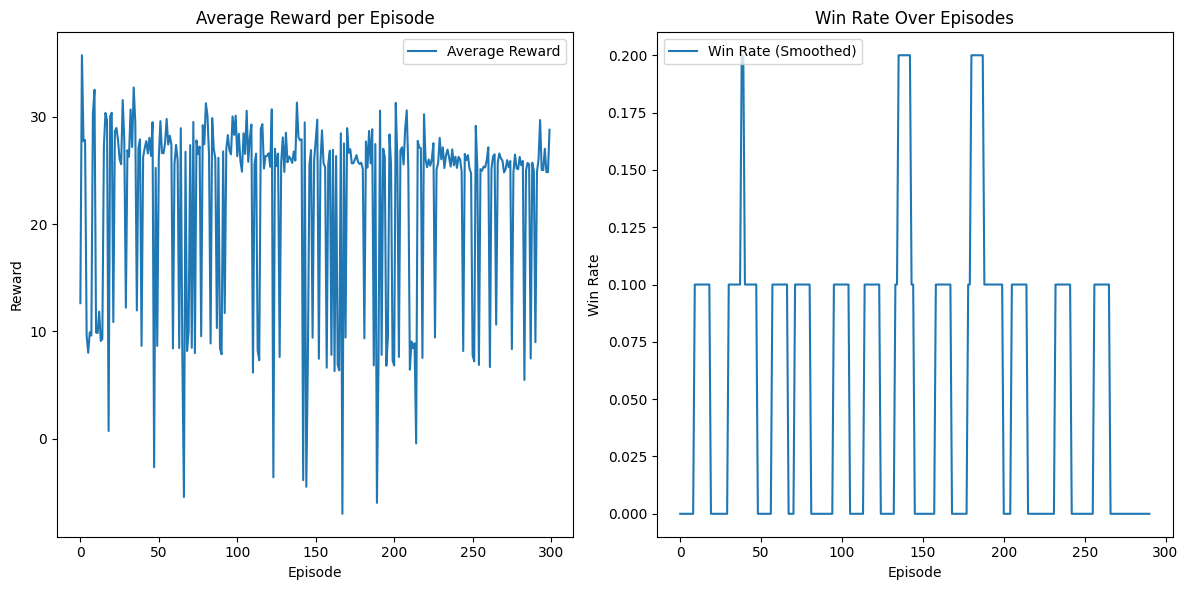

Training completed.


blue_player1_reward,▄▇██▇▇▇▇▃▇▇▃▃▇█▃▇▃██▇▃▁▇▇█▇▃▇▇▇▇▇▇▇▇▇▇▇▇
blue_player2_reward,▇▃▇▇█▁▇▇▇▄▇▇▇▇▇▇▇▇▇▃▇▃▇▃▇▃▇▇▇▇▇▇▇▇▇▇▆▇▇▆
episode,▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█████
epsilon,███▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
loss1,▁▁▁▃▁▃▁█▂▅▂▃▃▁▂▁▁▃▃▁▁▁▁▁▁▂▁▁▁▃▆▃▁▁▂▂▁▁▂▃
loss2,▁▁▁▅▁▁▁▁▄█▁▁▃▁▄▁▁▂▁▁▆▁▂▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁
score,████████▆███████████▅█▆▆▃█▆██▆█████▁█▃██
blue_player1_reward,14.4
blue_player2_reward,14.4
episode,299
epsilon,0.21224


In [39]:
name_experiment ='IQL_CNN_win'
wandb.init(project="", id = f"{name_experiment}__{datetime.now().strftime('%Y%m%d_%H%M%S')}")

train_iql(env, name_experiment, agent_q_networks, target_q_networks, replay_buffer, train_p, learn_p, random_enemy=False)
wandb.finish()


IQL on tiny with random enemy with scheduled learning_rate

In [ ]:
replay_buffer = ReplayBuffer()
name_experiment ='IQL_CNN_tiny'
train_p.epsilon = 0.55
env = gymPacMan_parallel_env(display=True, layout_file="layouts/tinyCapture.lay", length=200, enemieName='randomTeam.py', defenceReward=True)
wandb.init(project="", id = f"{name_experiment}__{datetime.now().strftime('%Y%m%d_%H%M%S')}")

train_iql(env, name_experiment, agent_q_networks, target_q_networks, replay_buffer, train_p, learn_p, random_enemy=False, schedule = True, later_exploration = True)
wandb.finish()


Loaded layout from file
Loading Team: c:\Users\josse\OneDrive\Documenten\creditcontract\RL\RL_MARL_QMIX//agents/randomTeam.py
Arguments: {}
Red team starts
enemy: randomTeam.py
Loading Team: c:\Users\josse\OneDrive\Documenten\creditcontract\RL\RL_MARL_QMIX//agents/randomTeam.py
Arguments: {}
Blue team starts
network action
network action


C:\Users\josse\AppData\Local\Temp\ipykernel_14928\3622664894.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs_agent, dtype=torch.float32).to(device)


network action
network action
network action
network action
network action
network action
network action
network action
network action
network action
network action
network action
network action
network action
network action
network action
network action
network action
network action
network action
network action
random action
network action
network action
random action
random action
random action
random action
random action
network action
network action
random action
random action
random action
random action
random action
random action
random action
random action
network action
network action
random action
random action
random action
random action
network action
random action
random action
random action
random action
network action
network action
random action
network action
network action
network action
network action
network action
random action
random action
random action
network action
network action
random action
network action
random action
network action
random action
random ac

In [45]:
wandb.finish()


blue_player1_reward,▁▁█▁
blue_player2_reward,▁▁█▁
episode,▁▃▆█
epsilon,█▆▃▁
loss1,▂▁▁▁▂▄▆▂▁▅▁▃▁▁▂▅▂▅▁▂▁▂▁▁▁▁▁▁▁▅▁▂▁▂▁▁▁▂▃█
loss2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▃▅█▁▅▇█▅▆▃▁█▂▂▁▁▁▁
lr,█▆▆▅▅▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████
score,▁▅█▅
blue_player1_reward,2.4
blue_player2_reward,2.4
episode,3


In [ ]:
import pandas as pd

# Define the list of enemies
enemies = ['randomTeam.py', 'baselineTeam.py', 'heuristicTeam.py', 'approxQTeam.py', 'MCTSTeam.py', 'AstarTeam.py']

# Initialize results dictionary
results = {enemy: {'wins': 0, 'losses': 0, 'draws': 0} for enemy in enemies}

# Number of games to play against each enemy
num_games = 10

# Function to evaluate the agent against an enemy
def evaluate_agent(env, enemy_name, num_games):
    wins, losses, draws = 0, 0, 0
    for _ in range(num_games):
        env.reset(enemieName=enemy_name)
        done = False
        while not done:
            actions = [-1 for _, _ in enumerate(env.agents)]
            states = []
            for i, agent_index in enumerate([1,3]):
                obs_agent = env.get_Observation(agent_index)
                state = torch.tensor(obs_agent, dtype=torch.float32).to(device)
                states.append(state)
                state = state.unsqueeze(0).to(device)  # Add batch dimension
                q_values = agent_q_networks[i](state)
                q_values = q_values.cpu().detach().numpy()
                action = np.random.choice(np.flatnonzero(q_values == q_values.max()))
                actions[agent_index] = action
            next_state, reward, done, info = env.step(actions)
            if done:
                if info['result'] == 'win':
                    wins += 1
                elif info['result'] == 'loss':
                    losses += 1
                else:
                    draws += 1
    return wins, losses, draws

# Evaluate the agent against each enemy
for enemy in enemies:
    env = gymPacMan_parallel_env(display=False, layout_file="layouts/smallCapture.lay", length=200, enemieName=enemy, defenceReward=True)
    wins, losses, draws = evaluate_agent(env, enemy, num_games)
    results[enemy]['wins'] = wins
    results[enemy]['losses'] = losses
    results[enemy]['draws'] = draws

# Convert results to a DataFrame for better display
results_df = pd.DataFrame(results).T
print(results_df)

**Testing idea's**

- experience buffer
- only exploration after first 10 steps
- 